# Generating Pseudo-Random Pulses

Paul Gasper, NREL

Documents the process of generating pseudo-random pulses used in this study.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.stats import norm
from pandas import DataFrame

In [2]:
def generate_prbs(pulse_durations, pulse_currents, total_duration, rest=30, dc_bias=0., dc_bias_mode='constant', seed=12345):
    """
    Generates a sequence of pulses with random durations and random currents drawn from the input sets.
    The sequence is mirrored so the total change of SOC is 0 (charge sustaining). A DC bias can be added
    to the sequence to make the pulse charge depleting (during discharge) or charge accumulating.
    
    Inputs
    ----------
    pulse_durations [int]: pulse times to choose from, e.x., np.linspace(2, 10, 4) to get [2, 4, 6, 8, 10]
    pulse_currents [int]: pulse currents to choose from, e.x., np.linspace(-3, 3, 5) to get [-3, -1.5, 0, 1.5, 3]
    total_duration [int]: total duration of the PRBS in seconds (even value, or rounded up if it isn't)
    rest [int] (default=30): rest duration in seconds before and after pulse test
    dc_bias [float] (default=0): apply a DC bias to the sequence
    dc_bias_mode [string] (default='constant'): method for applying the bias
        'constant': simply adds a DC bias current to the randomly generated pulses
        'weighted_dist': use a weighted distribution to pick pulse currents that will converge towards the dc_bias
    seed [int] (default=12345): seed random number generator

    Outputs
    ----------
    Total_Time: time vector for the pulse sequence in seconds
    Step: step number during the pulse sequence
    Step_Time: time vector for each individual current step in seconds
    Current: current magnitude at each seconds

    """
    # Make total_duration even
    total_duration += total_duration % 2 
    rng = np.random.default_rng(seed)

    # Generate step times and currents
    step_times = rng.choice(pulse_durations, total_duration)
    
    if dc_bias_mode == 'weighted_dist':
        # Check that the DC bias is within the range of the pulse currents
        assert(np.logical_or(dc_bias < np.max(pulse_currents), dc_bias > np.min(pulse_currents)))
        mu = dc_bias
        sigma = (np.max(pulse_currents) - np.min(pulse_currents))/3
        p = norm.pdf(pulse_currents, loc=mu, scale=sigma)
        # Instatiate current sampler
        currents = rng.choice(pulse_currents, total_duration, p=p/np.sum(p))

        # Only keep steps up until the duration
        mask = np.cumsum(step_times) < total_duration

        # Add a one onto the end of the sequence to grab one more value
        _mask = np.empty_like(mask)
        _mask[:1] = True
        _mask[1:] = mask[:-1]
        mask = _mask
        step_times = step_times[mask]
        currents = currents[mask]
        stepnums = np.arange(step_times.size) + 1

        # Change last step time so accumulated time is equal to duration/2
        sum_time = np.sum(step_times[:-1])
        step_times[-1] = total_duration - sum_time
    else:
        # Instatiate current sampler
        currents = rng.choice(pulse_currents, total_duration)

        # Only keep steps until half the duration
        mask = np.cumsum(step_times) < total_duration/2

        # Add a one onto the end of the sequence to grab one more value
        _mask = np.empty_like(mask)
        _mask[:1] = True
        _mask[1:] = mask[:-1]
        mask = _mask
        step_times = step_times[mask]
        currents = currents[mask]
        stepnums = np.arange(step_times.size) + 1

        # Change last step time so accumulated time is equal to duration/2
        sum_time = np.sum(step_times[:-1])
        step_times[-1] = total_duration/2 - sum_time
        
        # Mirror step times, currents, and stepnums
        step_times = np.int32(np.hstack((step_times, np.flip(step_times))))
        currents = np.hstack((currents, -1*np.flip(currents)))
        stepnums = np.int32(np.hstack((stepnums, stepnums+np.max(stepnums))))

    # Generate time vector, instantiate other vectors
    Total_Time = np.arange(total_duration)
    Step = np.zeros(Total_Time.shape)
    Step_Time = np.zeros(Total_Time.shape)
    Current = np.zeros(Total_Time.shape)
    # step through time vector, filling in random currents of random duration
    t=0
    idx = 0
    while t < total_duration:
        this_step_time = step_times[idx]
        this_step_current = currents[idx]
        this_step = stepnums[idx]
        if t + this_step_time < total_duration:
            Step[t:(t+this_step_time)] = this_step
            Step_Time[t:(t+this_step_time)] = np.arange(this_step_time)
            Current[t:(t+this_step_time)] = this_step_current
        else:
            Step[t:] = this_step
            Step_Time[t:] = np.arange(total_duration - t)
            Current[t:] = this_step_current
        idx += 1
        t += this_step_time
    
    if dc_bias_mode == 'constant':
        # Apply constant DC bias
        Current += dc_bias
    
    # Pre/postpend rest
    if rest > 0:
        Total_Time = np.hstack((np.arange(rest*2), Total_Time+rest*2))
        Step_Time = np.hstack((np.arange(rest), Step_Time, np.arange(rest)))
        Step = np.hstack((np.full((rest,), 1), Step+1, np.full((rest,), Step[-1]+2)))
        Current = np.hstack((np.zeros((rest,)), Current, np.zeros((rest,))))

    return (Total_Time, Step, Step_Time, Current)

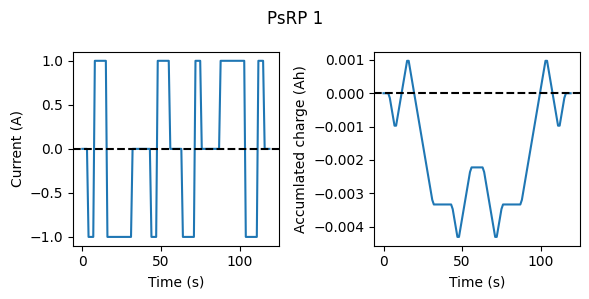

In [4]:
# PsRP_1 settings:
total_duration = 2*60
# pulse durations
start = 4
stop = 4
steps = 1
pulse_durations = np.linspace(start, stop, num=steps, dtype=int)
# pulse current
start = -1
stop = 1
steps = 3
pulse_currents = np.linspace(start, stop, num=steps)
# random seed
seed = 12

# Generate PRBS (default = charge sustaining)
(Total_Time, Step, Step_Time, Current) = generate_prbs(pulse_durations, pulse_currents, total_duration, seed=seed, rest=0)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(6,3))

ax[0].plot(Total_Time, Current)
ax[0].axhline(0, color='k', ls='--')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Current (A)')

ax[1].plot(Total_Time, integrate.cumulative_trapezoid(Current, initial=0)/3600)
ax[1].axhline(0, color='k', ls='--')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Accumlated charge (Ah)')

fig.suptitle('PsRP 1')
plt.tight_layout()

C:\Users\nprakash\AppData\Local\Temp\1\ipykernel_17628\2842597342.py:24: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  ah = integrate.cumtrapz(Current, initial=0)/3600


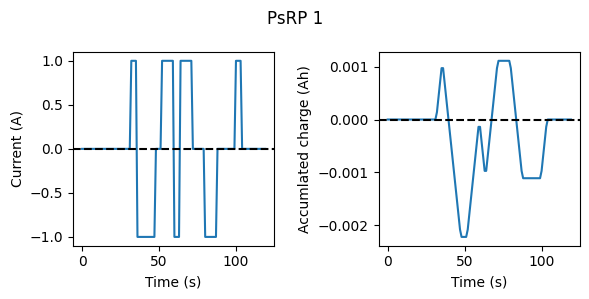

In [7]:
# PsRP_1 settings (weighted_dist 0 bias):
total_duration = 2*60
# pulse durations
start = 4
stop = 4
steps = 1
pulse_durations = np.linspace(start, stop, num=steps, dtype=int)
# pulse current
start = -1
stop = 1
steps = 3
pulse_currents = np.linspace(start, stop, num=steps)
# random seed
####seed = 26914452 # RESULT FROM WHILE LOOP BELOW, 11-22-2022 v1

# what should be the SOC change at 0 bias?
target = 0
# run a while loop until we find a random seed within X% of this value
psrp_ah = 100000000000
while np.abs(target - psrp_ah) > (1e-6):
    seed = np.random.randint(1, 1e8, 1)
    # Generate PRBS (default = charge sustaining)
    (Total_Time, Step, Step_Time, Current) = generate_prbs(pulse_durations, pulse_currents, total_duration, seed=seed, rest=0, dc_bias=0, dc_bias_mode='weighted_dist')
    ah = integrate.cumtrapz(Current, initial=0)/3600
    psrp_ah = ah[-1]

# Plot
fig, ax = plt.subplots(1, 2, figsize=(6,3))

ax[0].plot(Total_Time, Current)
ax[0].axhline(0, color='k', ls='--')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Current (A)')

ax[1].plot(Total_Time, integrate.cumulative_trapezoid(Current, initial=0)/3600)
ax[1].axhline(0, color='k', ls='--')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Accumlated charge (Ah)')

fig.suptitle('PsRP 1')
plt.tight_layout()

0.008333333333333333
0.008611111111111111


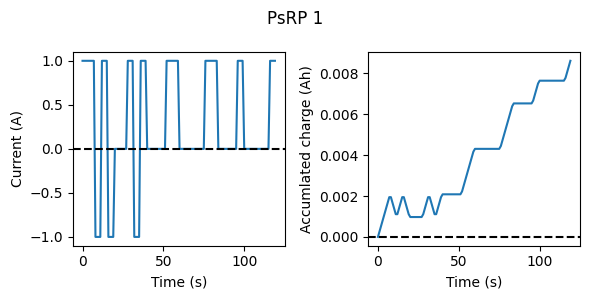

In [10]:
# PsRP_1 settings (weighted_dist 1/4 bias):
max_c_rate = 2
dc_bias_c_rate = 1/2

total_duration = 2*60
# pulse durations
start = 4
stop = 4
steps = 1
pulse_durations = np.linspace(start, stop, num=steps, dtype=int)
# pulse current
start = -1
stop = 1
steps = 3
pulse_currents = np.linspace(start, stop, num=steps)
# random seed
####seed = 36687938 # RESULT FROM WHILE LOOP BELOW, 2-28-2023 v1

# what should be the SOC change at 1/4 C bias?
target = ((1/max_c_rate) * dc_bias_c_rate) * (120/3600)
# run a while loop until we find a random seed within X% of this value
psrp_ah = 100000000000
while np.abs(target - psrp_ah) > (target * 0.035):
    seed = np.random.randint(1, 1e8, 1)
    # Generate PRBS (default = charge sustaining)
    (Total_Time, Step, Step_Time, Current) = generate_prbs(pulse_durations, pulse_currents, total_duration, seed=seed, rest=0, dc_bias=1/6, dc_bias_mode='weighted_dist')
    ah = integrate.cumulative_trapezoid(Current, initial=0)/3600
    psrp_ah = ah[-1]

print(target)
print(psrp_ah)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(6,3))

ax[0].plot(Total_Time, Current)
ax[0].axhline(0, color='k', ls='--')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Current (A)')

ax[1].plot(Total_Time, integrate.cumulative_trapezoid(Current, initial=0)/3600)
ax[1].axhline(0, color='k', ls='--')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Accumlated charge (Ah)')

fig.suptitle('PsRP 1')
plt.tight_layout()

In [19]:
df = DataFrame([Total_Time, Step, Step_Time, Current])
df.to_clipboard()

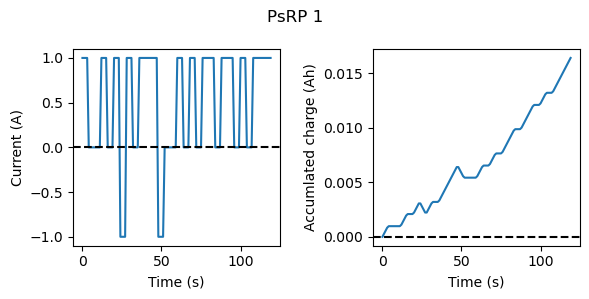

In [34]:
# PsRP_1 settings (weighted_dist 1 C bias):
max_c_rate = 2
dc_bias_c_rate = 1

total_duration = 2*60
# pulse durations
start = 4
stop = 4
steps = 1
pulse_durations = np.linspace(start, stop, num=steps, dtype=int)
# pulse current
start = -1
stop = 1
steps = 3
pulse_currents = np.linspace(start, stop, num=steps)
# random seed
####seed = 77718860 # RESULT FROM WHILE LOOP BELOW, 2-28-2023 v1

# what should be the SOC change at 1/4 C bias?
target = ((1/max_c_rate) * dc_bias_c_rate) * (120/3600)
# run a while loop until we find a random seed within X% of this value
psrp_ah = 100000000000
while np.abs(target - psrp_ah) > (target * 0.02):
    seed = np.random.randint(1, 1e8, 1)
    # Generate PRBS (default = charge sustaining)
    (Total_Time, Step, Step_Time, Current) = generate_prbs(pulse_durations, pulse_currents, total_duration, seed=seed, rest=0, dc_bias=1/3, dc_bias_mode='weighted_dist')
    ah = integrate.cumtrapz(Current, initial=0)/3600
    psrp_ah = ah[-1]

# Plot
fig, ax = plt.subplots(1, 2, figsize=(6,3))

ax[0].plot(Total_Time, Current)
ax[0].axhline(0, color='k', ls='--')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Current (A)')

ax[1].plot(Total_Time, integrate.cumtrapz(Current, initial=0)/3600)
ax[1].axhline(0, color='k', ls='--')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Accumlated charge (Ah)')

fig.suptitle('PsRP 1')
plt.tight_layout()

In [35]:
df = DataFrame([Total_Time, Step, Step_Time, Current])
df.to_clipboard()

In [37]:
seed

array([77718860])

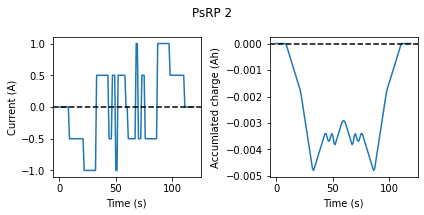

In [6]:
# PsRP_2 settings:
total_duration = 2*60
# pulse durations
start = 2
stop = 15
steps = 8
pulse_durations = np.linspace(start, stop, num=steps, dtype=int)
# pulse current
start = -1
stop = 1
steps = 5
pulse_currents = np.linspace(start, stop, num=steps)
# random seed
seed = 7142531

# Generate PRBS (default = charge sustaining)
(Total_Time, Step, Step_Time, Current) = generate_prbs(pulse_durations, pulse_currents, total_duration, seed=seed, rest=0)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(6,3))

ax[0].plot(Total_Time, Current)
ax[0].axhline(0, color='k', ls='--')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Current (A)')

ax[1].plot(Total_Time, integrate.cumtrapz(Current, initial=0)/3600)
ax[1].axhline(0, color='k', ls='--')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Accumlated charge (Ah)')

fig.suptitle('PsRP 2')
plt.tight_layout()

In [7]:
from pandas import DataFrame
df = DataFrame([Total_Time, Step, Step_Time, Current])

In [8]:
df.to_clipboard()

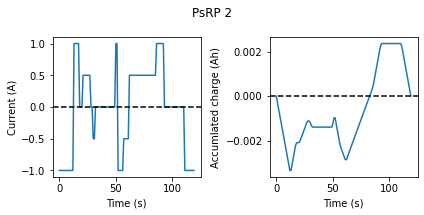

In [25]:
# PsRP_2 settings (weighted_dist 0 bias):
total_duration = 2*60
# pulse durations
start = 2
stop = 15
steps = 8
pulse_durations = np.linspace(start, stop, num=steps, dtype=int)
# pulse current
start = -1
stop = 1
steps = 5
pulse_currents = np.linspace(start, stop, num=steps)
# random seed
####seed = 26914452 # RESULT FROM WHILE LOOP BELOW, 11-22-2022 v1

# what should be the SOC change at 0 bias?
target = 0
# run a while loop until we find a random seed within X% of this value
psrp_ah = 100000000000
while np.abs(target - psrp_ah) > (1e-6):
    seed = np.random.randint(1, 1e8, 1)
    # Generate PRBS (default = charge sustaining)
    (Total_Time, Step, Step_Time, Current) = generate_prbs(pulse_durations, pulse_currents, total_duration, seed=seed, rest=0, dc_bias=0, dc_bias_mode='weighted_dist')
    ah = integrate.cumtrapz(Current, initial=0)/3600
    psrp_ah = ah[-1]

# Plot
fig, ax = plt.subplots(1, 2, figsize=(6,3))

ax[0].plot(Total_Time, Current)
ax[0].axhline(0, color='k', ls='--')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Current (A)')

ax[1].plot(Total_Time, integrate.cumtrapz(Current, initial=0)/3600)
ax[1].axhline(0, color='k', ls='--')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Accumlated charge (Ah)')

fig.suptitle('PsRP 2')
plt.tight_layout()

In [26]:
df = DataFrame([Total_Time, Step, Step_Time, Current])
df.to_clipboard()

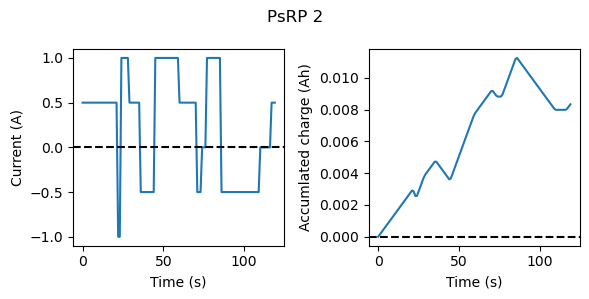

In [38]:
# PsRP_2 settings (weighted_dist C/2 bias):
max_c_rate = 2
dc_bias_c_rate = 1/2

total_duration = 2*60
# pulse durations
start = 2
stop = 15
steps = 8
pulse_durations = np.linspace(start, stop, num=steps, dtype=int)
# pulse current
start = -1
stop = 1
steps = 5
pulse_currents = np.linspace(start, stop, num=steps)
# random seed
####seed = 50411112 # RESULT FROM WHILE LOOP BELOW, 2-28-2023
# what should be the SOC change?
target = ((1/max_c_rate) * dc_bias_c_rate) * (120/3600)
# run a while loop until we find a random seed within X% of this value
psrp_ah = 100000000000
while np.abs(target - psrp_ah) > (target * 0.005):
    seed = np.random.randint(1, 1e8, 1)
    # Generate PRBS (default = charge sustaining)
    (Total_Time, Step, Step_Time, Current) = generate_prbs(pulse_durations, pulse_currents, total_duration, seed=seed, rest=0, dc_bias=1/6, dc_bias_mode='weighted_dist')
    ah = integrate.cumtrapz(Current, initial=0)/3600
    psrp_ah = ah[-1]

# Plot
fig, ax = plt.subplots(1, 2, figsize=(6,3))

ax[0].plot(Total_Time, Current)
ax[0].axhline(0, color='k', ls='--')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Current (A)')

ax[1].plot(Total_Time, integrate.cumtrapz(Current, initial=0)/3600)
ax[1].axhline(0, color='k', ls='--')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Accumlated charge (Ah)')

fig.suptitle('PsRP 2')
plt.tight_layout()

In [40]:
df = DataFrame([Total_Time, Step, Step_Time, Current])
df.to_clipboard()

In [39]:
seed

array([50411112])

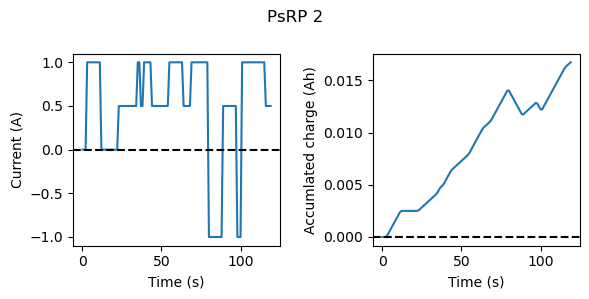

In [42]:
# PsRP_2 settings (weighted_dist 1 C bias):
max_c_rate = 2
dc_bias_c_rate = 1

total_duration = 2*60
# pulse durations
start = 2
stop = 15
steps = 8
pulse_durations = np.linspace(start, stop, num=steps, dtype=int)
# pulse current
start = -1
stop = 1
steps = 5
pulse_currents = np.linspace(start, stop, num=steps)
# random seed
####seed = 2490556 # RESULT FROM WHILE LOOP BELOW, 2-28-2023
# what should be the SOC change?
target = ((1/max_c_rate) * dc_bias_c_rate) * (120/3600)
# run a while loop until we find a random seed within X% of this value
psrp_ah = 100000000000
while np.abs(target - psrp_ah) > (target * 0.01):
    seed = np.random.randint(1, 1e8, 1)
    # Generate PRBS (default = charge sustaining)
    (Total_Time, Step, Step_Time, Current) = generate_prbs(pulse_durations, pulse_currents, total_duration, seed=seed, rest=0, dc_bias=1/3, dc_bias_mode='weighted_dist')
    ah = integrate.cumtrapz(Current, initial=0)/3600
    psrp_ah = ah[-1]

# Plot
fig, ax = plt.subplots(1, 2, figsize=(6,3))

ax[0].plot(Total_Time, Current)
ax[0].axhline(0, color='k', ls='--')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Current (A)')

ax[1].plot(Total_Time, integrate.cumtrapz(Current, initial=0)/3600)
ax[1].axhline(0, color='k', ls='--')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Accumlated charge (Ah)')

fig.suptitle('PsRP 2')
plt.tight_layout()

In [44]:
df = DataFrame([Total_Time, Step, Step_Time, Current])
df.to_clipboard()

In [43]:
seed

array([2490556])